In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import sys

sys.path.append('../TrainedNarrators/')
from data_utils import *
from model_utils import setupTokenizer

In [22]:
from nltk import sent_tokenize
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
nlp.add_pipe('sentencizer')
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [17]:
sent_count= lambda x: len(sent_tokenize(x))

In [3]:
from nltk import wordpunct_tokenize,word_tokenize
# Read the dataset
test_data = json.load(open('../dataset/test set.json'))
full_data= json.load(open('../dataset/annotation_data_with_augmentations.json'))['data']+test_data

In [37]:
test_data = json.load(open('../dataset/test set.json'))
test_sample = []
eval_tables = []
for pc in test_data:
    test_sample.append(processInputTableAndNarrations(
        pc, identical_metrics=identicals))
    # eval_tables.append(parseTableStructureForEval(pc,identicals))
rtest_sample = []
reval_tables = []
for pc in test_data:
    rtest_sample.append(processInputTableAndNarrations(
        pc, identical_metrics=identicals))

In [4]:
# Get task names
task_names = [d["task_name"] for d in full_data]

In [25]:
# Compute the number of unique words
mask_met=False
processed=[]
preambles = []
metrics ={1:[],2:[],3:[],4:[],}
# apply the preprocessing to the data
for idx,pc in enumerate(full_data):
    #print(idx)
    examples = processInputTableAndNarrations(pc, identical_metrics=identicals, augnment_metrics=False,)
    preambles.append(examples['preamble'])
    processed.append(examples)

In [26]:
len(processed)

825

In [9]:
from collections import Counter
import pickle as pk

In [7]:
# Number of anotations per task
task_dist = Counter(task_names)
print(f'The number of ML tasks {len(task_dist)}')

The number of ML tasks 58


In [32]:
processed = pk.load(open('../dataset/train_dataset_new.dat', 'rb'))

In [11]:
len(processed)

4529

In [9]:
# Average number of narrations per task
mean_annotations = np.average([v for b,v in dict(task_dist).items()])
print(f'The average number of annotations submitted: {int(mean_annotations)}')

The average number of annotations submitted: 14


In [18]:
narrations = ' '.join([pc['narration'].lower() for pc in processed]).split()

In [19]:
words = Counter(narrations)

In [20]:
print(f'The number of unique words is: {len(words)}')

The number of unique words is: 3548


In [38]:
# Compute the average number of sentences per annotation 
narr_count = [sent_count(pc['narration']) for pc in processed+test_sample]
nn= [idx for idx, pc in enumerate(processed) if sent_count(pc['narration']) ==9]

In [39]:
np.mean(narr_count)

3.6487362281270252

In [40]:
dict(Counter(narr_count))

{3: 1844, 4: 1403, 5: 446, 6: 194, 2: 579, 7: 110, 8: 53}

### Most of the narrations have about 3 sentences summarizing the performance of the corresponding classifier

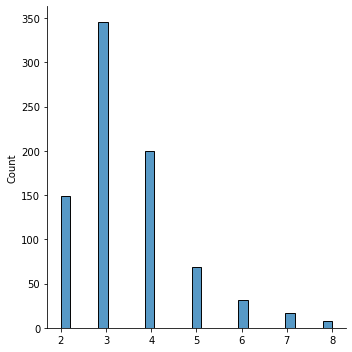

In [18]:
import seaborn as sns
sns.displot(narr_count)

In [19]:
def processMetricsDataChecks(metric_scores, metric_rates, augment=False, identicals={}, nb_metrics=6):
    pp = pd.read_json(json.loads(metric_scores))
    metric_rates = json.loads(metric_rates)
    if augment:
        temp_cols = pp.columns.to_list()
        random.shuffle(temp_cols)
        pp = pp[temp_cols]
    metrics = [s.strip() for s in pp.columns.to_list()]
    metric_rates = {s.strip(): v for s, v in metric_rates.items()}
    values = pp.values.tolist()[0]

    metrics_score_string = '<TM> '

    # Make sure the ratings of all metrics are provided
    #print(metrics, metric_rates.keys())
    assert set(metrics) == set(list(metric_rates.keys()))

    metrics_info = []
    metrics_list = []
    values_list = []
    rates_list = []
    for idx, (m, v) in enumerate(zip(metrics, values)):
        mx = m.lower().replace('-score', '').strip()
        mx = m.lower().replace(' score', '').strip()
        mx = m.lower().replace('score', '').strip()
        score_rate = ''
        if int(metric_rates.get(m, 0)) in [4, 5]:
            score_rate = 'HIGH'
        elif int(metric_rates.get(m, 0)) in [3]:
            score_rate = 'MODERATE'
        else:
            score_rate = 'LOW'

        metrics_list.append(m.replace('-', '').lower())
        values_list.append(f'{roundN(v,2)}%')
        rates_list.append(f'{score_rate}')
    return [(a,b,c) for a,b,c in zip(metrics_list,rates_list,values_list)]

In [20]:
# Make a rough estimate of number of models per each task.
# Compute the number of unique words
mask_met=False
taskNames_samples= {}
preambles = {}
pream = {}
# apply the preprocessing to the data
for idx,pc in enumerate(full_data):
    #print(idx)
    tn = pc['task_name']
    examples = processInputTableAndNarrations(pc, identical_metrics=identicals, augnment_metrics=False,)
    pp = processMetricsDataChecks(pc["metrics_values"],pc["imetric_score_rate"],identicals=identicals)
    if tn not in preambles.keys():
        preambles[tn]= []
        pream[tn] = []
        taskNames_samples[tn]= []
    preambles[tn].append(examples['preamble'])
    taskNames_samples[tn].append(examples)
    pream[tn].append(pp)

In [21]:
#pream['UPS customer service Ratings']

In [22]:
tns={}
for tn,elems in pream.items():
    po=[]
    for p in elems:
        po = po+p
    tns[tn] = Counter([p[0] for p in list(set(po))]).most_common(1)[0][-1]

In [23]:
tns['UPS customer service Ratings']

2

In [25]:
np.mean([v for v in tns.values()])

6.551724137931035

For this NLG task, the goal is generating analytical sentences based on the evaluation metrics' scores achieved by any given classification model. 
To generate the dataset for this study, different ML models were trained on a number of classification tasks across different application domains. 
For each classifier, experts were asked to rate the scores achieved for a given set of metrics. 
Based on the ratings assigned, metrics' scores, and information on the dataset distribution across the class labels, they were also asked to write analytical statements summarising the classification performance of the corresponding model. 
A carefully designed pre-processing routine is applied to remove invalid submissions resulting in 612 high-quality data-sentence pairs. The training, validation and test set consists of 582 data-sentence pairs, 30 data-sentence pairs, and 30 data-sentence pairs, respectively.

### The dataset contains narrations of models or classifiers trained on 58 different machine learning problems. However, only classification tasks were considered. We leave regression tasks for future work.

### Across each classification task, about 6 different model were trained. These models include random forest, support vector machines, gradient boosting, logistic regression, and KNN. 

### The annotators were asked to summarized the performance of the model based on different combination of metric scores. For simplicity only the most common classification metrics were considered. These are accuracy, precision, AUC, recall, specificity, F1-score and F2-score. This implies that the NLG models trained on this dataset will struggle to produce a valid summary of input with unknown metrics.

### 